In [1]:
# Import necessary packages
import numpy as np
import cobra
import cobra.flux_analysis
import pygad
import copy
import matplotlib.pyplot as plt

In [2]:
from cobra.io import load_model

In [3]:
# Load a metabolic model
model = load_model("e_coli_core")

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [4]:
model2 = load_model("e_coli_core")

In [5]:
model2.reactions

[<Reaction PFK at 0x7f8b653051d0>,
 <Reaction PFL at 0x7f8bbca213d0>,
 <Reaction PGI at 0x7f8bbca226d0>,
 <Reaction PGK at 0x7f8bbca24ad0>,
 <Reaction PGL at 0x7f8bbca24a50>,
 <Reaction ACALD at 0x7f8bbca24550>,
 <Reaction AKGt2r at 0x7f8bbca27290>,
 <Reaction PGM at 0x7f8bbc9a8fd0>,
 <Reaction PIt2r at 0x7f8bbca27d50>,
 <Reaction ALCD2x at 0x7f8bbc9aac50>,
 <Reaction ACALDt at 0x7f8bbc9ab950>,
 <Reaction ACKr at 0x7f8bbc9aba90>,
 <Reaction PPC at 0x7f8bbc9ab850>,
 <Reaction ACONTa at 0x7f8bbc9ade50>,
 <Reaction ACONTb at 0x7f8bbc9ace90>,
 <Reaction ATPM at 0x7f8bbc9b15d0>,
 <Reaction PPCK at 0x7f8bbca21cd0>,
 <Reaction ACt2r at 0x7f8bbc9ae090>,
 <Reaction PPS at 0x7f8bbc9b1b50>,
 <Reaction ADK1 at 0x7f8bbc9b1790>,
 <Reaction AKGDH at 0x7f8bbc9ad6d0>,
 <Reaction ATPS4r at 0x7f8bbc9b9790>,
 <Reaction PTAr at 0x7f8bbc9c5490>,
 <Reaction PYK at 0x7f8bbc9caa90>,
 <Reaction BIOMASS_Ecoli_core_w_GAM at 0x7f8bbc9ca850>,
 <Reaction PYRt2 at 0x7f8bbc9c1fd0>,
 <Reaction CO2t at 0x7f8bbc9cacd0>,


In [6]:
model2.objective='BIOMASS_Ecoli_core_w_GAM'#'y001882' #yali.reactions.xBIOMASS

In [7]:
solution = model2.optimize()
solution

,fluxes,reduced_costs
PFK,7.477382,-1.387779e-17
PFL,0.000000,2.081668e-17
PGI,4.860861,0.000000e+00
PGK,-16.023526,6.938894e-18
PGL,4.959985,1.517883e-17
...,...,...
NADH16,38.534610,0.000000e+00
NADTRHD,0.000000,-2.546243e-03
NH4t,4.765319,-1.387779e-17
O2t,21.799493,0.000000e+00


In [8]:
model2.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
nh4_e,EX_nh4_e,4.765,0,0.00%
o2_e,EX_o2_e,21.8,0,0.00%
pi_e,EX_pi_e,3.215,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-22.81,1,100.00%
h2o_e,EX_h2o_e,-29.18,0,0.00%
h_e,EX_h_e,-17.53,0,0.00%


In [9]:
def fitness_func(ga_instance, solution, solution_idx):
    # Create a deep copy of the model
    model_copy = copy.deepcopy(model)
    
    # Manipulate the model with the solution
    for i, reaction in enumerate(model.reactions):
        flux = solution[i]
        if flux >= 0:
            reaction.lower_bound = 0
            reaction.upper_bound = flux
        else:
            reaction.lower_bound = flux
            reaction.upper_bound = 0
            
    # Check mass balance
    for reaction in model.reactions:
        if not reaction.check_mass_balance() == {}:
            # If the mass balance is violated, return a low fitness value
            # or eliminate this solution
            return 0

    # Perform FBA
    solution = model.optimize()
    print(solution)
    
    # Return the objective value (biomass production)
    return solution.objective_value

In [10]:
# Create a GA instance
ga_instance = pygad.GA(
    num_generations=100,
    num_parents_mating=5,
    fitness_func=fitness_func,
    sol_per_pop=10,
    num_genes=len(model.reactions)*2,
    gene_type=float,
    init_range_low=0.0,
    init_range_high=1000.0,
)

In [11]:
# Run the GA
ga_instance.run()

In [12]:
# Return the best solution
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Best solution: ", solution)
print("Best solution fitness: ", solution_fitness)

Best solution:  [316.73355288 371.38522066 376.89751372 981.31689688 448.39351426
 600.44736993 380.00916038 377.83531635 508.12918743 126.61753601
 974.56653339 364.29842046 347.74547532 668.00548022 790.25668584
  16.63052821 586.88456309 851.92340236  82.35087179 702.11156265
   6.94609317 312.41203879 402.32252993 381.83343061 680.71218677
 136.72808864 662.01164827 905.62976738 655.30616007  77.59950975
 109.34343769 200.79813613 842.44385637 293.54937211  53.2713141
 491.68429537 481.22575661 973.08973342 258.52689898 197.81091372
  59.35546721 377.68360029 370.74399623 484.49579367 560.96771438
 946.18107723  30.97020783  30.58263085 691.06729894 836.54556513
 713.6093019  904.76440146 341.35994354 709.06861266 475.27822738
 964.74446969 550.52851853 865.70330453 633.74260248 437.47394461
 955.10130303 963.53619282 547.29398303 723.43960122   9.24579032
 221.53202719 481.24066113 910.76971897  24.76798986 787.41096202
 501.4453364   56.97222004 841.6850031  594.06543315 696.7813

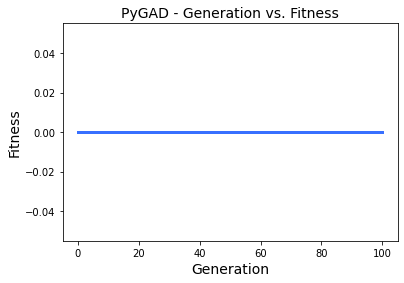

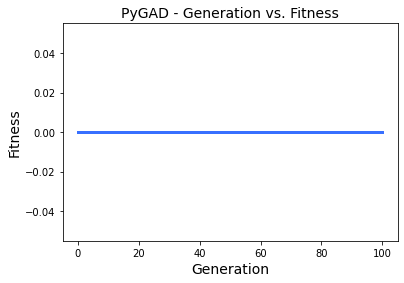

In [13]:
ga_instance.plot_fitness()

In [14]:
# Evaluate original model
original_solution = model.optimize()
original_biomass = original_solution.objective_value

# Evaluate optimized model
model_copy = model.copy()
for i, reaction in enumerate(model_copy.reactions):
    flux = solution[i]
    if flux >= 0:
        reaction.lower_bound = 0
        reaction.upper_bound = flux
    else:
        reaction.lower_bound = flux
        reaction.upper_bound = 0
optimized_solution = model_copy.optimize()
optimized_biomass = optimized_solution.objective_value

# Compare biomass production
print(f"Original biomass production: {original_biomass}")
print(f"Optimized biomass production: {optimized_biomass}")


Original biomass production: 0.0
Optimized biomass production: 0.0


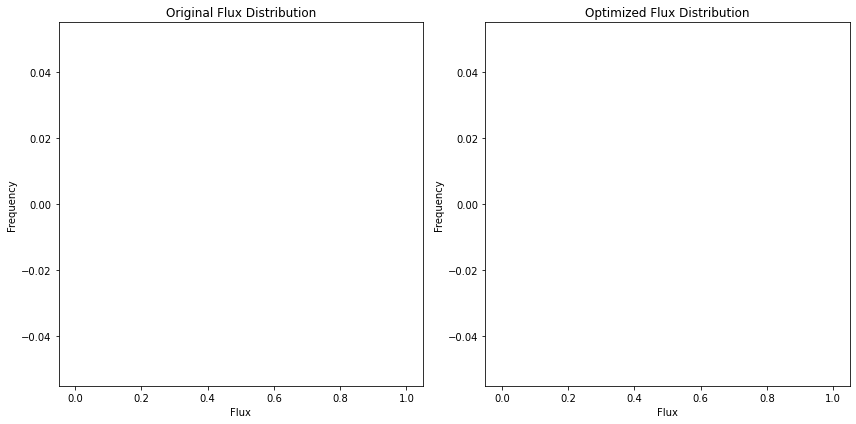

In [15]:
# Compare flux distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist([flux for flux in original_solution.fluxes if abs(flux) > 1e-6])  # exclude near-zero fluxes
plt.title("Original Flux Distribution")
plt.xlabel("Flux")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist([flux for flux in optimized_solution.fluxes if abs(flux) > 1e-6])  # exclude near-zero fluxes
plt.title("Optimized Flux Distribution")
plt.xlabel("Flux")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1,) and (101,)

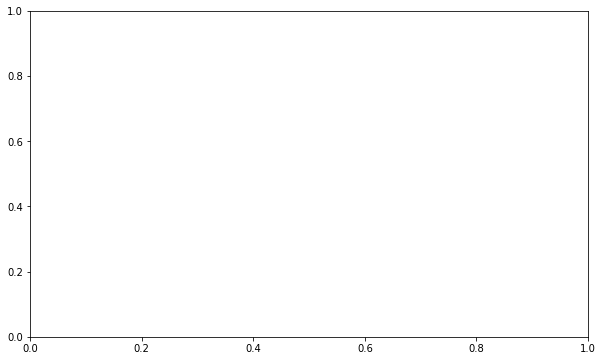

In [16]:

# Plot GA progress
plt.figure(figsize=(10, 6))
plt.plot(ga_instance.generations_completed, ga_instance.best_solutions_fitness)
plt.title("GA Progress")
plt.xlabel("Generation")
plt.ylabel("Best Fitness (Biomass Production)")
plt.show()